In [10]:
!pip install mlem torchvision tensorflow numpy torch torchaudio --upgrade
!pip install mlem==0.4.6 --no-deps
!pip install iterative-telemetry==0.0.7 --ignore-requires-python --no-deps
!pip install pydantic==1.10.2 --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.5/218.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 44.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 836.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.3/216.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.5/214.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 18.8 MB/s eta 0:0

In [11]:
from __future__ import print_function
from __future__ import division

import copy
import typing
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import OrderedDict

# Нейронки
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision import io as torch_io
from torchvision import models as torch_models

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


# Параметры

In [12]:
class WorkingMode:
    TRAIN: str = "train"
    VAL: str = "val"

In [13]:
INPUT_DIR: Path = Path("/kaggle/input/")
OUTPUT_DIR: Path = Path("/kaggle/working/")

FINAL_DATASET_DIR: Path = INPUT_DIR / "art-price" / "dataset"
WORKING_MODES: typing.List[WorkingMode] = [WorkingMode.TRAIN, WorkingMode.VAL]

DATASET_DIRS: typing.Dict[WorkingMode, Path] = {
    mode: FINAL_DATASET_DIR / mode
    for mode in WORKING_MODES
}
ANNOTATIONS_PATHS: typing.Dict[WorkingMode, Path] = {
    mode: FINAL_DATASET_DIR / f"{mode}.csv"
    for mode in WORKING_MODES
}
    
BATCH_SIZE: int = 64
N_WORKERS: int = 4
MODELS_DIR: Path = OUTPUT_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

MODEL_CLASS: typing.Type[nn.Module] = torch_models.efficientnet_b3
MODELS_WEIGHTS = torch_models.EfficientNet_B3_Weights.IMAGENET1K_V1

# Detect if we have a GPU available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


# Создание модели pytorch

Выбрал модель классификации изображений https://pytorch.org/vision/stable/models.html#:~:text=EfficientNet_B3_Weights.IMAGENET1K_V1 как оптимальную по соотношению качество/скорость работы.

## Проверим модель

In [14]:
def predict_by_model(img_path: Path, model: nn.Module, transforms=None) -> torch.Tensor:
    img = torch_io.read_image(str(img_path), mode=torch_io.image.ImageReadMode.RGB)
    if transforms:
        img = transforms(img)
    
    batch = img.unsqueeze(0)
    
    model.eval()
    prediction = model(batch).squeeze(0)
    
    return prediction

In [15]:
img_path: Path = DATASET_DIRS[WorkingMode.TRAIN] / "19.png"

# Initialize model with the best available weights and the inference transforms
model: nn.Module = MODEL_CLASS(weights=MODELS_WEIGHTS)
transforms = MODELS_WEIGHTS.transforms()

prediction: torch.Tensor = predict_by_model(img_path=img_path, model=model, transforms=transforms)
probs: torch.Tensor = prediction.softmax(0)

# Use the model and print the predicted category
class_id: int = prediction.argmax().item()
score = probs[class_id].item()
category_name = MODELS_WEIGHTS.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

pitcher: 58.7%


## Load data

In [16]:
class ImagePricingDataset(Dataset):

    def __init__(self, csv_path: Path, root_dir: Path, transform=None):
        """
        Args:
            csv_path: Path to the csv file with annotations.
            root_dir: directory with all the images.
            transform: Optional transform to be applied on a sample.
        """
        self.df: pd.DataFrame = pd.read_csv(csv_path)
        self.root_dir: Path = root_dir
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        annotation: pd.Series = self.df.iloc[idx]
        
        img_path: Path = self.root_dir / annotation["image"]
        image = torch_io.read_image(str(img_path), mode=torch_io.image.ImageReadMode.RGB)
        if self.transform:
            image = self.transform(image)
        
        price = annotation["price"]
        return {'image': image, 'price': torch.tensor(price)}

### Посмотрим на примеры (проверим ImagePricingDataset)

0 tensor(28500) torch.Size([3, 440, 653]) torch.Size([])
1 tensor(3000) torch.Size([3, 653, 653]) torch.Size([])
2 tensor(5000) torch.Size([3, 653, 467]) torch.Size([])
3 tensor(5000) torch.Size([3, 653, 472]) torch.Size([])
4 tensor(2500) torch.Size([3, 653, 653]) torch.Size([])


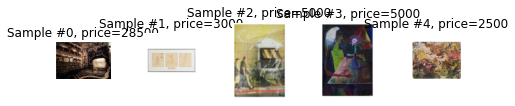

In [17]:
n_images: int = 5
tmp_dataset: ImagePricingDataset = ImagePricingDataset(
    csv_path=ANNOTATIONS_PATHS[WorkingMode.TRAIN], 
    root_dir=DATASET_DIRS[WorkingMode.TRAIN], 
    transform=None,
)
    
fig = plt.figure()
for i in range(len(tmp_dataset)):
    sample = tmp_dataset[i]

    print(i, sample['price'], sample['image'].shape, sample['price'].shape)

    ax = plt.subplot(1, n_images, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}, price={sample['price']}")
    ax.axis('off')
    plt.imshow(sample['image'].permute(1, 2, 0))

    if i == (n_images - 1):
        plt.show()
        break

DataLoader(ImagePricingDataset)

In [18]:
tmp_dataset: ImagePricingDataset = ImagePricingDataset(
    csv_path=ANNOTATIONS_PATHS[WorkingMode.TRAIN], 
    root_dir=DATASET_DIRS[WorkingMode.TRAIN], 
    transform=MODELS_WEIGHTS.transforms(),
)
tmp_dataloader: DataLoader = DataLoader(tmp_dataset, batch_size=5, shuffle=False, num_workers=0)

for i, batch in enumerate(tmp_dataloader):
    print(i, batch["image"].size(), batch["price"].size(), batch["price"])
    if i == 2:
        break

0 torch.Size([5, 3, 300, 300]) torch.Size([5]) tensor([28500,  3000,  5000,  5000,  2500])
1 torch.Size([5, 3, 300, 300]) torch.Size([5]) tensor([7575, 7550, 3550, 3075, 3550])
2 torch.Size([5, 3, 300, 300]) torch.Size([5]) tensor([ 3075, 40000, 15000,  7000,  4000])


## DataLoadres

In [19]:
print("Initializing Datasets and Dataloaders...")

data_transforms = {mode: MODELS_WEIGHTS.transforms() for mode in WORKING_MODES}

# Create training and validation datasets
image_datasets: typing.Dict[WorkingMode, ImagePricingDataset] = {
    mode: ImagePricingDataset(
        csv_path=ANNOTATIONS_PATHS[mode], 
        root_dir=DATASET_DIRS[mode], 
        transform=data_transforms[mode],
    )
    for mode in WORKING_MODES
}

# Create training and validation dataloaders
dataloaders: typing.Dict[WorkingMode, DataLoader] = {
    mode: DataLoader(image_datasets[mode], batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS) 
    for mode in WORKING_MODES
}

Initializing Datasets and Dataloaders...


# Создадим модель для дообучения

In [20]:
def set_parameter_requires_grad(model: nn.Module, requires_grad: bool = False):
    for param in model.parameters():
        param.requires_grad = False

In [21]:
def create_model(model_class: typing.Type[nn.Module], weights, freeze_body: bool = True) -> nn.Module:
    model: nn.Module = model_class(weights=weights)
    print(f"Orig classiffier layer (last layer): \n{model.classifier}\n")
    
    if freeze_body:
        set_parameter_requires_grad(model=model, requires_grad=False)

    n_in_features: int = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(n_in_features, 1)
    print(f"New classiffier layer (last layer): \n{model.classifier}")
    
    return model

In [22]:
model: nn.Module = create_model(model_class=MODEL_CLASS, weights=MODELS_WEIGHTS, freeze_body=True)

Orig classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

New classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1, bias=True)
)


## Model saving/loading

In [23]:
def save_model_weights(model: nn.Module, model_name: str, model_dir: Path) -> Path:
    model_dir.mkdir(parents=True, exist_ok=True)
    weights_path: Path = model_dir / f"{model_name}_weights.pt"

    torch.save(model.state_dict(), weights_path)
    
    return weights_path


def load_from_weights(model: nn.Module, weights_path: Path) -> nn.Module:
    """Only weights."""
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    return model

# def save_model(model: nn.Module, model_name: str, model_dir: Path) -> typing.Tuple[Path, Path]:
#     model_dir.mkdir(parents=True, exist_ok=True)
#     weights_path: Path = model_dir / f"{model_name}_weights.pt"
#     model_path: Path = model_dir / f"{model_name}_model.pt"

#     torch.save(model.state_dict(), weights_path)
#     torch.save(model, model_path)
    
#     return weights_path, model_path

# def load_model(model_path: Path) -> nn.Module:
#     """!!!Like pickle => use class name for loading => don't work, because we change last layer?."""
#     model: nn.Module = torch.load(final_model_path)
#     model.eval()
#     return model

In [24]:
model_name: str = "dummy"
model_dir: Path = MODELS_DIR / model_name
dummy_model: nn.Module = create_model(model_class=MODEL_CLASS, weights=MODELS_WEIGHTS, freeze_body=True)
weights_path = save_model_weights(dummy_model, model_name=model_name, model_dir=model_dir)

# Load
new_model: nn.Module = create_model(model_class=MODEL_CLASS, weights=MODELS_WEIGHTS, freeze_body=True)
new_model = load_from_weights(model=new_model, weights_path=weights_path)
print("Loaded from weights")


# # Strict model
# other_model: nn.Module = load_model(model_path)
# print("Loaded model")

Orig classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

New classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1, bias=True)
)
Orig classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

New classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1, bias=True)
)
Loaded from weights


In [25]:
img_path: Path = DATASET_DIRS[WorkingMode.TRAIN] / "19.png"
transforms = MODELS_WEIGHTS.transforms()

dummy_prediction: torch.Tensor = predict_by_model(img_path=img_path, model=dummy_model, transforms=transforms)
new_prediction: torch.Tensor = predict_by_model(img_path=img_path, model=new_model, transforms=transforms)
# other_prediction: torch.Tensor = predict_by_model(img_path=img_path, model=other_model, transforms=transforms)

print(dummy_prediction, new_prediction)

tensor([-0.0013], grad_fn=<SqueezeBackward1>) tensor([-0.0013], grad_fn=<SqueezeBackward1>)


### Оптимизатор и Функция потерь

In [26]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update, lr=0.001)
criterion = nn.MSELoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


# Обучение модели

In [27]:
def rmsle(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return torch.mean((torch.log10(y_true) - torch.log10(y_pred))**2)

In [53]:
def run_epoch(
    working_mode: WorkingMode, 
    model: nn.Module, 
    dataloader: DataLoader, 
    criterion, 
    optimizer, 
    num_epochs: int = 5
) -> float:
    """Run one full epoch of train/val process."""
    start_date: datetime.datetime = datetime.datetime.now()
    print(f"{working_mode} start time: {start_date}")

    is_train: bool = (working_mode == WorkingMode.TRAIN)
    if is_train:
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode

    sum_std_err_running_loss: float = 0.0
    sum_std_log_err_running_loss: float = 0.0
    dataset_size: int = len(dataloader.dataset)

    # Iterate over data.
    for batch in tqdm(dataloader, total=dataset_size // dataloader.batch_size):
        inputs = batch["image"].to(DEVICE)
        prices = batch["price"].to(DEVICE)

        log_prices = torch.log10(prices)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(is_train):
            # Get model outputs and calculate loss

            log_pred_prices = model(inputs).reshape(-1)
            loss = criterion(log_pred_prices, log_prices)

            pred_prices = torch.pow(10, log_pred_prices).detach()

            # backward + optimize only if in training phase
            if is_train:
                loss.backward()
                optimizer.step()

        # statistics
        sum_std_err_running_loss += loss.item() * inputs.size(0)
        sum_std_log_err_running_loss += ((torch.log10(prices) - torch.log10(pred_prices))**2).sum().item()
#         break

    epoch_rmse: float = np.sqrt(sum_std_err_running_loss / dataset_size)
    epoch_rmsle: float = np.sqrt(sum_std_log_err_running_loss / dataset_size)

    end_date: datetime.datetime = datetime.datetime.now()
    time_delta: datetime.timedelta = end_date - start_date
    print(f"Epoch complete in {time_delta}")
    print(f"{working_mode} RMSLE: {epoch_rmsle:.4f}, RMSE: {epoch_rmse:.4f}")
    
    return epoch_rmsle

In [54]:
model: nn.Module = create_model(model_class=MODEL_CLASS, weights=MODELS_WEIGHTS, freeze_body=True)

Orig classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

New classiffier layer (last layer): 
Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1, bias=True)
)


In [55]:
N_EPOCHES: int = 25
start_epoch: int = 1

model_name: str = "orig_dataset"
model_dir: Path = MODELS_DIR / model_name

In [ ]:
start_date: datetime.datetime = datetime.datetime.now()
print(f"Start time: {start_date}")

val_rmsle_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_rmsle = np.inf

for epoch in range(start_epoch, N_EPOCHES + 1):
    try:
        print("-" * 80)
        print(f"Epoch {epoch}/{N_EPOCHES}")
        print("-" * 80)

        # Each epoch has a training and validation phase
        for mode in WORKING_MODES:
            epoch_rmsle: float = run_epoch(
                working_mode=mode,
                model=model, 
                dataloader=dataloaders[mode], 
                criterion=criterion, 
                optimizer=optimizer,
            )

            # deep copy the model
            if mode == WorkingMode.VAL:
                val_rmsle_history.append(epoch_rmsle)

                if epoch_rmsle < best_rmsle:
                    best_rmsle = epoch_rmsle
                    best_model_wts = copy.deepcopy(model.state_dict())
                    weights_path = save_model_weights(model=model, model_name=f"best_{model_name}", model_dir=model_dir)

        weights_path = save_model_weights(model=model, model_name=f"{epoch}_{model_name}", model_dir=model_dir)

        end_date: datetime.datetime = datetime.datetime.now()
        time_delta: datetime.timedelta = end_date - start_date
        print(f"Epoch complete in {time_delta}")
        print(f"Best rmsle: {best_rmsle:4f}")
        print("\n")
        
    except KeyboardInterrupt:
        weights_path = save_model_weights(
            model=model, 
            model_name=f"INTERRUPTED_{model_name}_{datetime.datetime.now()}", 
            model_dir=model_dir,
        )
        print('Saved interrupted model')
        raise KeyboardInterrupt

Start time: 2023-04-13 18:20:07.132725
--------------------------------------------------------------------------------
Epoch 1/25
--------------------------------------------------------------------------------
train start time: 2023-04-13 18:20:07.180976


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch complete in 0:03:13.214364
train RMSLE: 3.6646, RMSE: 3.6646
val start time: 2023-04-13 18:23:20.410623


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch complete in 0:00:30.371843
val RMSLE: 2.9205, RMSE: 2.9205
Epoch complete in 0:03:43.993183
Best rmsle: 2.920458


--------------------------------------------------------------------------------
Epoch 2/25
--------------------------------------------------------------------------------
train start time: 2023-04-13 18:23:51.126166


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from mlem.api import save

save(
    model, 
    "/kaggle/working/models/price_keras_preprocess", 
    preprocess=lambda x: np.expand_dims(x[:224,:224,:3], 0),
    sample_data=img,
);

In [ ]:
!zip -r price_keras_preprocess.zip models/price_keras_preprocess.mlem models/price_keras_preprocess